<a href="https://colab.research.google.com/github/NgocMinhUniversityProjects/ML_MR/blob/main/MR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTL mở rộng môn Học Máy, mã môn học CO3117 - Hidden model Markov
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |




In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
epsilon = 1e-14

# Normal baum-welch

### Thuật toán Forward

Thuật toán **Forward** được sử dụng để giải quyết bài toán 1 của HMM: Tính toán xác suất của một chuỗi quan sát $P(O | \lambda)$ cho trước, với mô hình $\lambda = (A, B, \pi)$.

Thuật toán này sử dụng quy hoạch động để tính biến $\alpha_t(i)$, là xác suất của chuỗi quan sát $O_1, O_2, ..., O_t$ và trạng thái tại thời điểm $t$ là $S_i$.

- **Khởi tạo:** $\alpha_1(i) = \pi_i b_i(O_1)$
- **Truy hồi:** $\alpha_{t+1}(j) = \left[ \sum_{i=1}^{N} \alpha_t(i) a_{ij} \right] b_j(O_{t+1})$
- **Kết thúc:** $P(O | \lambda) = \sum_{i=1}^{N} \alpha_T(i)$

In [46]:
def forward(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    alpha[0, :] = pi * B[:, obs[0]]
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs[t]]
    return np.sum(alpha[-1, :]), alpha

### Thuật toán Backward

Thuật toán **Backward** tương tự như Forward nhưng tính toán ngược từ cuối chuỗi. Biến $\beta_t(i)$ được định nghĩa là xác suất của chuỗi quan sát từ $t+1$ đến cuối ($O_{t+1}, ..., O_T$), cho biết trạng thái tại thời điểm $t$ là $S_i$.

Thuật toán này thường được kết hợp với Forward trong thuật toán Baum-Welch.

- **Khởi tạo:** $\beta_T(i) = 1$
- **Truy hồi:** $\beta_t(i) = \sum_{j=1}^{N} a_{ij} b_j(O_{t+1}) \beta_{t+1}(j)$

In [47]:
def backward(obs, A, B):
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((T, N))
    beta[T-1, :] = 1
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[t+1, :])

    return beta

### Thuật toán Baum-Welch 
Thuật toán **Baum-Welch** (còn gọi là Forward-Backward) được sử dụng để giải quyết bài toán 3: Huấn luyện mô hình (ước lượng tham số $\lambda = (A, B, \pi)$) từ một chuỗi quan sát $O$. Đây là một trường hợp đặc biệt của thuật toán Expectation-Maximization (EM).

1.  **E-step (Expectation):** Tính toán các biến $\gamma_t(i)$ (xác suất ở trạng thái $i$ tại thời điểm $t$) và $\xi_t(i, j)$ (xác suất chuyển từ trạng thái $i$ sang $j$ tại thời điểm $t$).
    - $\gamma_t(i) = \frac{\alpha_t(i) \beta_t(i)}{P(O | \lambda)}$
    - $\xi_t(i, j) = \frac{\alpha_t(i) a_{ij} b_j(O_{t+1}) \beta_{t+1}(j)}{P(O | \lambda)}$
2.  **M-step (Maximization):** Cập nhật lại các tham số $\pi$, $A$, và $B$ dựa trên các giá trị kỳ vọng đã tính.
    - $\pi_i = \gamma_1(i)$
    - $a_{ij} = \frac{\sum_{t=1}^{T-1} \xi_t(i, j)}{\sum_{t=1}^{T-1} \gamma_t(i)}$
    - $b_j(k) = \frac{\sum_{t=1 \text{ s.t. } O_t=k}^{T} \gamma_t(j)}{\sum_{t=1}^{T} \gamma_t(j)}$

Hàm `baum_welch` dưới đây thực hiện lặp lại hai bước E và M này `n_iter` lần để hội tụ các tham số.

In [48]:
# obs : short for observation sequence
# N : number of hidden states
# M : number of possible symbols

def baum_welch(obs, N, M, n_iter=100, returnLog = False):
    T = len(obs)
    A = np.random.dirichlet(np.ones(N), size=N)
    B = np.random.dirichlet(np.ones(M), size=N)
    pi = np.random.dirichlet(np.ones(N))

    A_arr = []
    B_arr = []
    pi_arr = []
    prob_arr = []

    for iteration in range(n_iter):
        P,alpha=forward(obs,A,B,pi)
        beta = backward(obs, A, B)

        if returnLog:
          A_arr.append(A)
          B_arr.append(B)
          pi_arr.append(pi)
          prob_arr.append(P)

        xi = np.zeros((T - 1, N, N))
        for t in range(T - 1):
            denom = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]).sum()
            xi[t] = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]) / denom
        gamma = xi.sum(axis=2)
        gamma = np.vstack([gamma, (alpha[-1] * beta[-1]) / P])

        pi = gamma[0]
        A = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None])

        for k in range(M):
            B[:, k] = gamma[np.array(obs) == k].sum(axis=0)
        B = B / (gamma.sum(axis=0)[:, None])

    if returnLog:
      return A_arr, B_arr, pi_arr, prob_arr

    return A, B, pi # Guessed parameters

# Scaled baum-welch

In [49]:
def forward_log_scaled(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    c = np.zeros(T)   # scaling factors

    alpha[0, :] = pi * B[:, obs[0]]
    c[0] = 1.0 / np.sum(alpha[0, :])
    alpha[0, :] *= c[0]

    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs[t]]
        c[t] = 1.0 / np.sum(alpha[t, :])
        alpha[t, :] *= c[t]

    log_prob = -np.sum(np.log(c)) # Apply log
    return log_prob, alpha, c


In [50]:
def backward_log_scaled(obs, A, B, c):
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((T, N))

    beta[T-1, :] = c[T-1]   # scale

    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[t+1, :])
        beta[t, :] *= c[t]   # apply scaling

    return beta


In [51]:
def baum_welch_scaled(obs, N, M, max_iter=100, returnLog = False):
    T = len(obs)

    A = np.random.dirichlet(np.ones(N), size=N)
    B = np.random.dirichlet(np.ones(M), size=N)
    pi = np.random.dirichlet(np.ones(N))

    A_arr = []
    B_arr = []
    pi_arr = []
    prob_arr = []


    for iteration in range(max_iter):
        log_prob, alpha, c = forward_log_scaled(obs, A, B, pi)
        beta = backward_log_scaled(obs, A, B, c)

        if(returnLog):
          A_arr.append(A)
          B_arr.append(B)
          pi_arr.append(pi)
          prob_arr.append(log_prob)

        xi = np.zeros((T-1, N, N))
        for t in range(T-1):
            denom = np.sum(alpha[t][:, None] * A * B[:, obs[t+1]] * beta[t+1])
            if denom == 0: denom = epsilon
            xi[t] = (alpha[t][:, None] * A * B[:, obs[t+1]] * beta[t+1]) / denom

        # Remnomalizes gamma
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        pi = gamma[0]
        A = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None] + epsilon)

        for k in range(M):
            mask = np.array(obs) == k
            if np.any(mask):
                B[:, k] = gamma[mask].sum(axis=0)
        B = B / (gamma.sum(axis=0)[:, None] + epsilon)

    if returnLog:
      return A_arr, B_arr, pi_arr, prob_arr

    return A, B, pi


# Viterbi

Thuật toán **Viterbi** được sử dụng để giải quyết bài toán 2: Tìm chuỗi trạng thái ẩn $Q = (q_1, q_2, ..., q_T)$ "tốt nhất" (có xác suất cao nhất) đã sinh ra chuỗi quan sát $O$.

Đây cũng là một thuật toán quy hoạch động:
- $\delta_t(i)$ là xác suất cao nhất của chuỗi trạng thái kết thúc tại trạng thái $i$ ở thời điểm $t$.
- $\psi_t(i)$ lưu lại trạng thái "tốt nhất" ở thời điểm $t-1$ dẫn đến trạng thái $i$ ở thời điểm $t$.

- **Khởi tạo:**
    - $\delta_1(i) = \pi_i b_i(O_1)$
    - $\psi_1(i) = 0$
- **Truy hồi:**
    - $\delta_t(j) = \max_{i} [\delta_{t-1}(i) a_{ij}] b_j(O_t)$
    - $\psi_t(j) = \arg\max_{i} [\delta_{t-1}(i) a_{ij}]$
- **Kết thúc:** Tìm chuỗi trạng thái bằng cách quay lui (backtracking) từ $\psi$.

In [52]:
# obs : short for observation sequence
# A : transition probability matrix N x N
# B : state emission probability matrix N x M
# pi : initial distribution

def viterbi(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    delta = np.zeros((T, N)) # Max probability array for any sequence to end in state index i
    psi = np.zeros((T, N), dtype=int) # argmax back pointer

    delta[0, :] = pi * B[:, obs[0]]

    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1, :] * A[:, j]
            psi[t, j] = np.argmax(seq_probs)
            delta[t, j] = np.max(seq_probs) * B[j, obs[t]]

    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1, :])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]

    return states, delta, psi

# Test HMM for predicition

In [53]:
def predict_next(obs, A, B, pi, length=1, random=True):
    # log_prob, alpha, c = forward_log_scaled(obs, A, B, pi)
    # returns the states visited as well

    _,alpha=forward(obs, A, B, pi)
    state_dist = alpha[-1, :] / np.sum(alpha[-1, :])

    predictions = []
    states = []
    for _ in range(length):
        next_state_dist = state_dist @ A
        next_obs_dist = next_state_dist @ B

        # normalize both
        next_state_dist /= np.sum(next_state_dist)
        next_obs_dist /= np.sum(next_obs_dist)

        if(random):
          next_obs = np.random.choice(len(next_obs_dist), p=next_obs_dist)
          next_state = np.random.choice(len(next_state_dist), p=next_state_dist)
          state_dist = np.zeros_like(state_dist)
          state_dist[next_state] = 1.0
        else :
          next_state = np.argmax(next_state_dist)
          next_obs = np.argmax(next_obs_dist)
          state_dist = next_state_dist

        states.append(next_state)
        predictions.append(next_obs)

    return predictions, states


In [54]:
def max_likelihood_obs(A, B, pi, len = 10):
  obs = []
  start_state = np.argmax(pi)
  obs.append(start_state)
  return predict_next(obs, A, B, pi, len, False)

# Test and visualize

In [55]:
def viewHMM(A, B, pi):
  fig, ax = plt.subplots(1, 3, figsize=(16, 4))

  # --- Transition matrix A ---
  im = ax[0].imshow(A, cmap="viridis")
  ax[0].set_title("Transition Matrix A")
  ax[0].set_xlabel("To state")
  ax[0].set_ylabel("From state")
  fig.colorbar(im, ax=ax[0])

  # --- Emission matrix B ---
  im = ax[1].imshow(B, cmap="plasma")
  ax[1].set_title("Emission Matrix B")
  ax[1].set_xlabel("Emission")
  ax[1].set_ylabel("State")
  fig.colorbar(im, ax=ax[1])

  # --- Initial distribution pi ---
  ax[2].bar(range(len(pi)), pi)
  ax[2].set_title("Initial Distribution π")
  ax[2].set_xlabel("State")
  ax[2].set_ylabel("Probability")

  plt.tight_layout()
plt.show()

## Plot log probability of baum-welch over time

In [56]:
def plot_prob(prob_arr, max_iter):
  plt.plot(np.arange(max_iter), prob_arr)
  plt.xlabel("Iteration")
  plt.ylabel("Log Probability")
  plt.show()

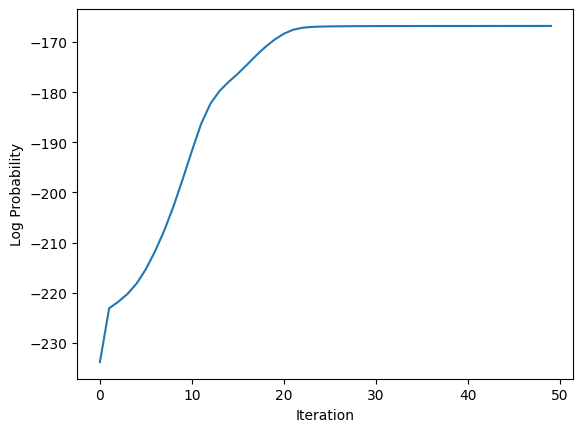

In [57]:
obs = np.random.randint(0, 10, 100)
N = 10
M = 10

max_iter = 50

A_arr, B_arr, pi_arr, prob_arr = baum_welch_scaled(obs, N, M, max_iter, True)
plot_prob(prob_arr, max_iter)

# probability should monotonically increases
# then flatten
# this graph is good

## Compare a maximum likelihood observation with viterbi output (fixxed HMM)

In [58]:
# 2 x 2 HMM model
A_original = np.array([[0.7, 0.3], [0.4, 0.6]])
B_original = np.array([[0.1, 0.9], [0.9, 0.1]])
pi_original = np.array([0.5, 0.5])

A = A_original
B = B_original
pi = pi_original

print("Original:", A, B, pi)

obs, states = max_likelihood_obs(A, B, pi, 100)
print("Test observation (len = 10):", obs)

A_v, _, _ = viterbi(obs, A, B, pi)

print("States visited:", states)
print("Viterbi output (len = 10):", A_v)

diff = A_v - states

print("Number of differences:", np.count_nonzero(diff))

# No difference --> viterbi behaves correctly

Original: [[0.7 0.3]
 [0.4 0.6]] [[0.1 0.9]
 [0.9 0.1]] [0.5 0.5]
Test observation (len = 10): [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int6

## Compare test HMM with one obtained from baum-welch with maximum likely observation

Max-likelihood observation from original (len = 100): [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/tmp/ipython-input-2271835081.py:6: RuntimeWarning: invalid value encountered in divide
  state_dist = alpha[-1, :] / np.sum(alpha[-1, :])


Max-likelihood observation from obtained (len = 100): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

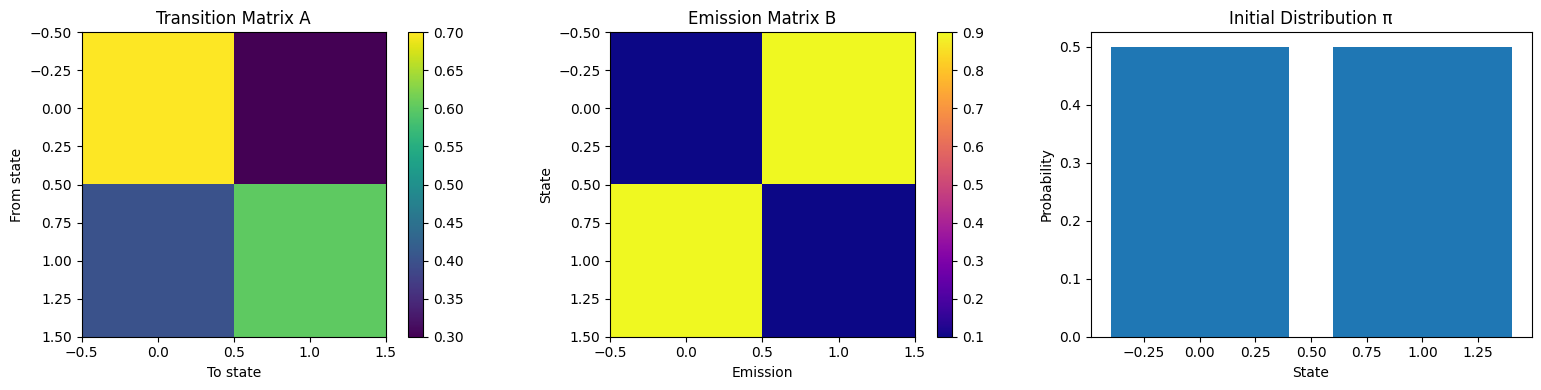

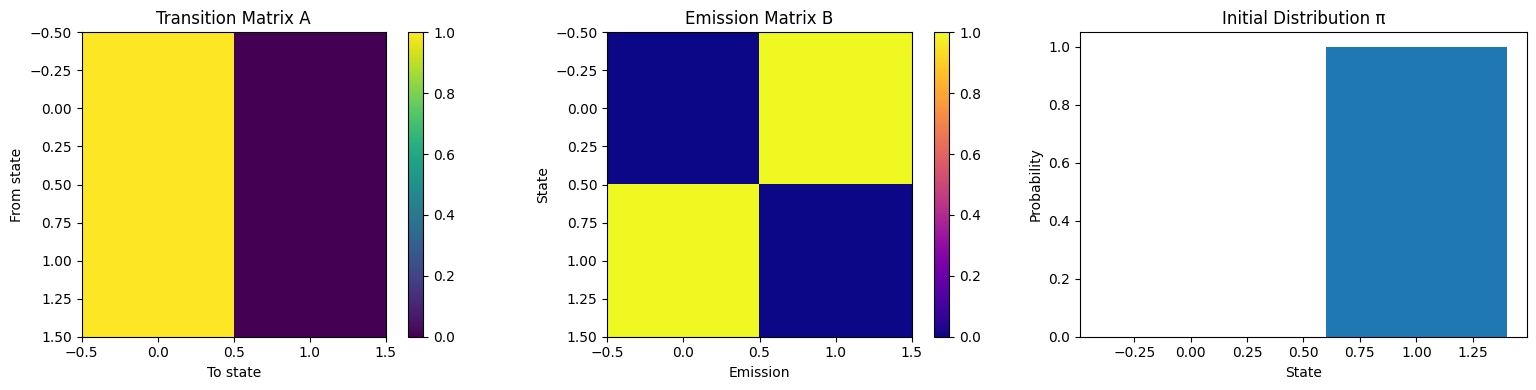

In [59]:
viewHMM(A, B, pi)

obs, states = max_likelihood_obs(A, B, pi, 1000)
print("Max-likelihood observation from original (len = 100):", [int(o) for o in obs])

M = 2
N = 2

A, B, pi = baum_welch_scaled(obs, N, M, 50)

viewHMM(A, B, pi)

obs2, states2 = max_likelihood_obs(A, B, pi, 1000)
print("Max-likelihood observation from obtained (len = 100):", [int(o) for o in obs2])

# compare obs
diff = np.subtract(obs2, obs)

print("Number of differences in observation:", np.count_nonzero(diff))

# compare states

diff = np.subtract(states2, states)

print("Number of differences in states traveled:", np.count_nonzero(diff))

## Compares learned A, B and pi to the original

In [60]:
from itertools import permutations

def best_permutation_match(A_true, B_true, pi_true, A_learn, B_learn, pi_learn):
    """
    Return permutation of learned states that best matches true states
    by minimizing Frobenius distance of (A,B,pi) combined.
    """
    N = A_true.shape[0]
    assert A_learn.shape == (N,N)
    best_perm = None
    best_score = np.inf

    # try scipy Hungarian for speed if available
    try:
        from scipy.optimize import linear_sum_assignment
        # build cost matrix: cost[i,j] = distance between true state i and learned state j
        cost = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                # distance between rows/cols of A, rows of B, and pi entries
                da = np.linalg.norm(A_true[i,:] - A_learn[j,:]) + np.linalg.norm(A_true[:,i] - A_learn[:,j])
                db = np.linalg.norm(B_true[i,:] - B_learn[j,:])
                dp = abs(pi_true[i] - pi_learn[j])
                cost[i,j] = da + db + dp
        row_ind, col_ind = linear_sum_assignment(cost)
        # col_ind maps true state i -> learned state col_ind[i]
        perm = list(col_ind)
        # construct permutation array p where new_index = perm[old_index]
        best_perm = perm
    except Exception:
        # brute force (ok for small N <= 6)
        for perm in permutations(range(N)):
            perm = list(perm)
            # apply perm to learned matrices (permute rows and columns)
            A_p = A_learn[np.ix_(perm, perm)]
            B_p = B_learn[perm,:]
            pi_p = pi_learn[perm]
            score = np.linalg.norm(A_true - A_p) + np.linalg.norm(B_true - B_p) + np.linalg.norm(pi_true - pi_p)
            if score < best_score:
                best_score = score
                best_perm = perm

    return best_perm

def permute_learned(A_learn, B_learn, pi_learn, perm):
    A_p = A_learn[np.ix_(perm, perm)]
    B_p = B_learn[perm, :]
    pi_p = pi_learn[perm]
    return A_p, B_p, pi_p

def compare(A_true, B_true, pi_true, A_learn, B_learn, pi_learn):
    # Align permutation
    perm = best_permutation_match(A_true, B_true, pi_true, A_learn, B_learn, pi_learn)
    A_p, B_p, pi_p = permute_learned(A_learn, B_learn, pi_learn, perm)

    # Compute L1/L2
    results = {}
    results['perm'] = perm
    results['A_L1'] = np.linalg.norm(A_true - A_p, ord=1)
    results['A_L2'] = np.linalg.norm(A_true - A_p)
    results['B_L1'] = np.linalg.norm(B_true - B_p, ord=1)
    results['B_L2'] = np.linalg.norm(B_true - B_p)
    results['pi_L1'] = np.linalg.norm(pi_true - pi_p, ord=1)
    results['pi_L2'] = np.linalg.norm(pi_true - pi_p)

    # KL (careful with zeros)
    eps = 1e-12
    def kl(p, q):
        p = np.clip(p, eps, 1)
        q = np.clip(q, eps, 1)
        return np.sum(p * np.log(p / q))
    results['A_KL'] = np.sum([kl(A_true[i], A_p[i]) for i in range(A_true.shape[0])])
    results['B_KL'] = np.sum([kl(B_true[i], B_p[i]) for i in range(B_true.shape[0])])
    results['pi_KL'] = kl(pi_true, pi_p)

    return results

def state_confusion(true_states, inferred_states, perm=None):
    # If perm provided, remap inferred states
    if perm is not None:
        inv_map = {perm[i]: i for i in range(len(perm))}  # learned->true idx
        remapped = np.array([inv_map[s] for s in inferred_states])
    else:
        remapped = np.array(inferred_states)
    # confusion matrix
    N = max(true_states.max(), remapped.max()) + 1
    conf = np.zeros((N,N), dtype=int)
    for t, r in zip(true_states, remapped):
        conf[t, r] += 1
    return conf


def summarize(stats):
    def assess_L2(x):
        if x < 0.05:
            return "very close"
        elif x < 0.2:
            return "slightly different"
        elif x < 0.5:
            return "moderately different"
        else:
            return "significantly different"

    def assess_KL(x):
        if x < 0.1:
            return "distributions almost identical"
        elif x < 1:
            return "slightly different distributions"
        elif x < 5:
            return "noticeably different distributions"
        else:
            return "very different distributions"

    print("=== HMM Parameter Difference Summary ===")
    print(f"State permutation mapping used: {stats.get('perm')}")

    # -------- A --------
    print("\n[Transition Matrix A]")
    print(f"  L2 difference: {stats['A_L2']:.4f} → {assess_L2(stats['A_L2'])}")
    print(f"  KL divergence: {stats['A_KL']:.4f} → {assess_KL(stats['A_KL'])}")

    # -------- B --------
    print("\n[Emission Matrix B]")
    print(f"  L2 difference: {stats['B_L2']:.4f} → {assess_L2(stats['B_L2'])}")
    print(f"  KL divergence: {stats['B_KL']:.4f} → {assess_KL(stats['B_KL'])}")

    # -------- pi --------
    print("\n[Initial Distribution π]")
    print(f"  L2 difference: {stats['pi_L2']:.4f} → {assess_L2(stats['pi_L2'])}")
    print(f"  KL divergence: {stats['pi_KL']:.4f} → {assess_KL(stats['pi_KL'])}")

    # -------- high-level conclusion --------
    print("\n=== Interpretation ===")

    # A
    if stats['A_L2'] < 0.2 and stats['A_KL'] < 1:
        print("• Transition matrix A was recovered well.")
    else:
        print("• Transition matrix A differs noticeably.")

    # B
    if stats['B_KL'] > 5:
        print("• Emission matrix B is numerically very different (expected for EM),")
        print("  but may still produce the same prediction behavior.")
    elif stats['B_L2'] < 0.2:
        print("• Emission matrix B is close to original.")
    else:
        print("• Emission matrix B is moderately different.")

    # π
    if stats['pi_KL'] > 5:
        print("• Initial distribution π changed a lot (expected, since long sequences make π irrelevant).")
    else:
        print("• π is reasonably close to the original.")

    print("========================================")

compare_res = compare(A_original, B_original, pi_original, A, B, pi)

print("Comparison stat:")
print(compare_res)
summarize(compare_res)

Comparison stat:
{'perm': [np.int64(0), np.int64(1)], 'A_L1': np.float64(0.8999999999999999), 'A_L2': np.float64(0.9486832980505074), 'B_L1': np.float64(0.19999999999999998), 'B_L2': np.float64(0.199999999999995), 'pi_L1': np.float64(1.0), 'pi_L2': np.float64(0.7071067811865476), 'A_KL': np.float64(23.584043035271545), 'B_KL': np.float64(4.876038276402823), 'pi_KL': np.float64(13.12236337740433)}
=== HMM Parameter Difference Summary ===
State permutation mapping used: [np.int64(0), np.int64(1)]

[Transition Matrix A]
  L2 difference: 0.9487 → significantly different
  KL divergence: 23.5840 → very different distributions

[Emission Matrix B]
  L2 difference: 0.2000 → slightly different
  KL divergence: 4.8760 → noticeably different distributions

[Initial Distribution π]
  L2 difference: 0.7071 → significantly different
  KL divergence: 13.1224 → very different distributions

=== Interpretation ===
• Transition matrix A differs noticeably.
• Emission matrix B is close to original.
• In

## View states traveled

In [61]:
def plot_state_path(states, title="State Path"):
    T = len(states)
    plt.figure(figsize=(14, 10))

    plt.step(range(T), states, where='post')
    plt.yticks(sorted(np.unique(states)))
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.title(title)
    plt.grid(True, alpha=0.3)

    plt.show()

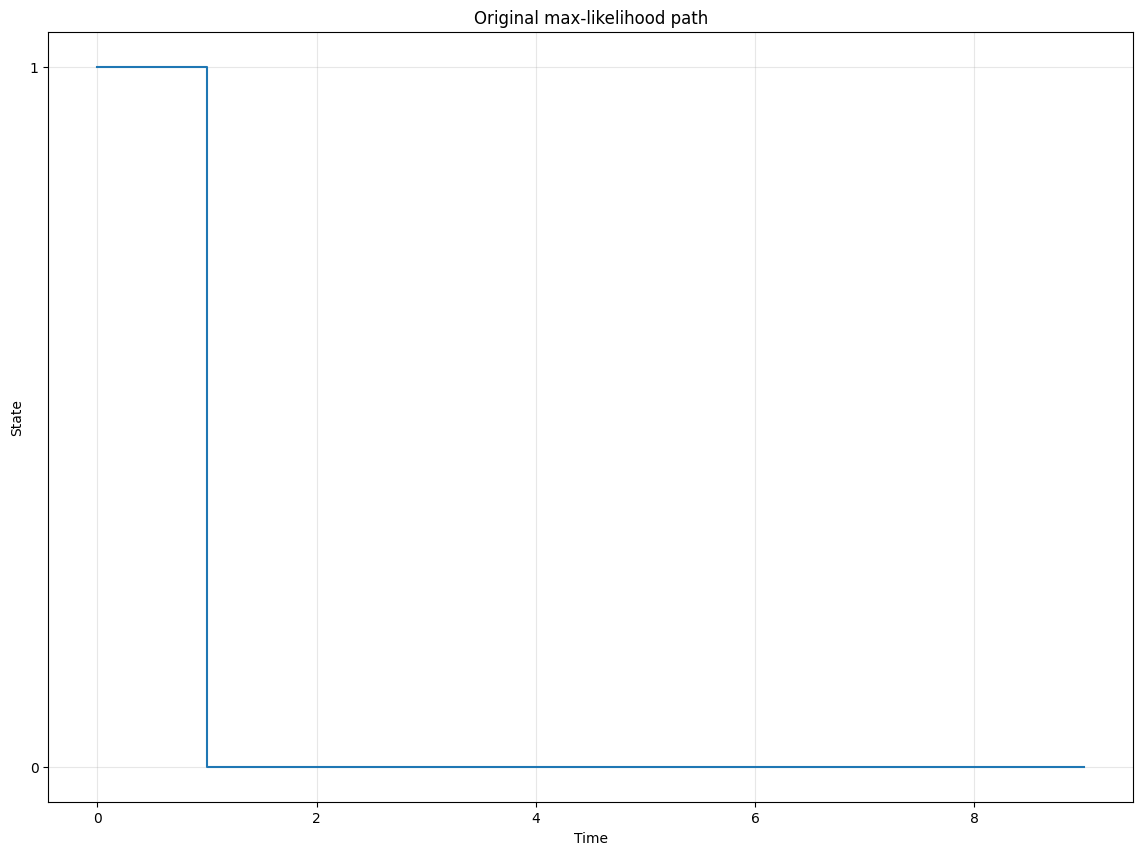

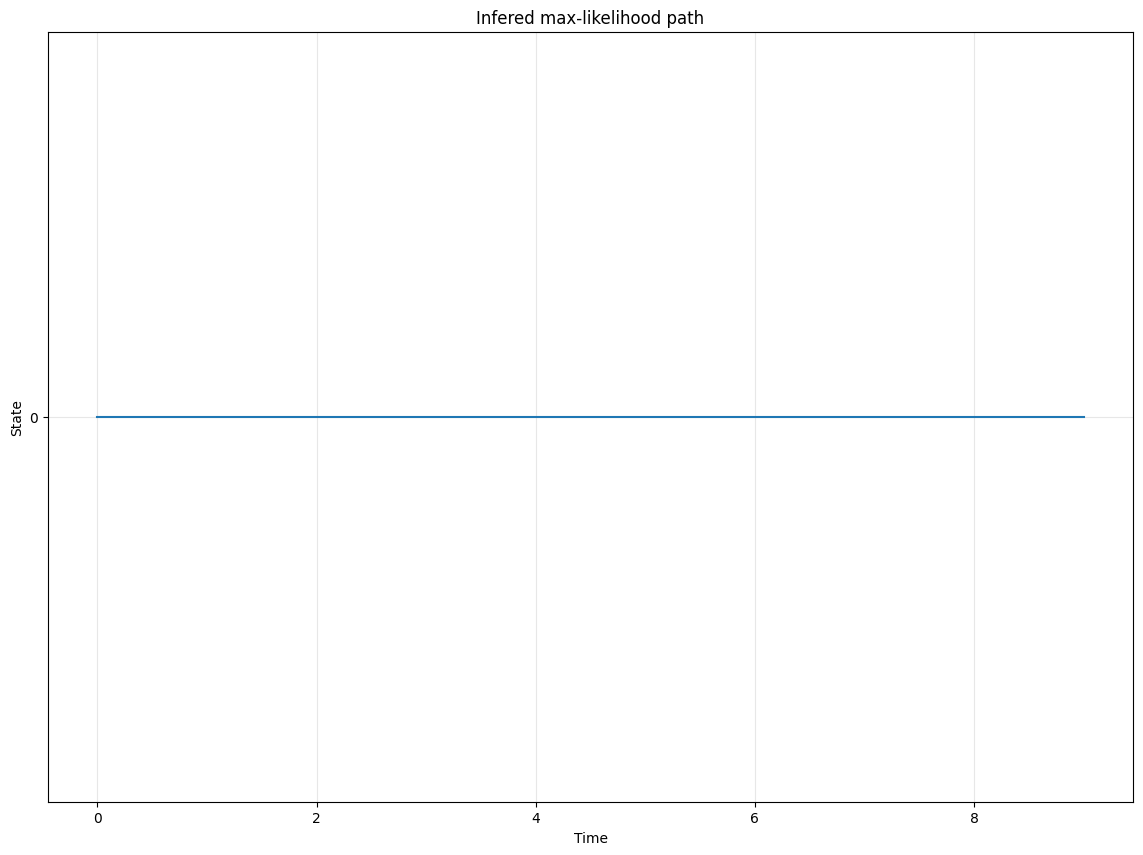

In [62]:
plot_state_path(states[:10], "Original max-likelihood path")
plot_state_path(states2[:10], "Infered max-likelihood path")

## Visualize a more complex HMM - Weather

Phần này sử dụng các hàm HMM đã cài đặt để dự đoán thời tiết.
- **Bài toán:** Dự đoán thời tiết cho 5 "mốc" thời gian tiếp theo (mỗi mốc 6 giờ) dựa trên dữ liệu thời tiết 2 tuần đã qua.
- **Dữ liệu:** `obs` là chuỗi quan sát thời tiết (0: Nắng, 1: Mây, 2: Mưa).
- **Trạng thái ẩn (N):** Chúng ta không biết các trạng thái ẩn (ví dụ: áp suất, độ ẩm, nhiệt độ) là gì. Ở đây ta *đoán* số lượng trạng thái ẩn là 50 (`N = 50`).
- **Huấn luyện:** Dùng `baum_welch` (học không giám sát) để tìm ra các ma trận A, B và vector pi từ chuỗi `obs`.
- **Dự đoán:** Dùng hàm `predict_next` để dự đoán 5 quan sát tiếp theo.

In [80]:
# 0 = clear / sunny
# 1 = clouddy
# 2 = rainny
# Real weather for the past 2 weeks, each entries is 6 hours, entered at sep 29, 2025
# Manually enteredd from https://www.timeanddate.com/weather/vietnam/ho-chi-minh/historic

weather_symbols = ["☀️", "⛅", "☔"]
obs_weather = [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]

N = 100 # pure guess, 2 humidity level * 5 temperatures * 10
M = 3
A_arr, B_arr, pi_arr, prob_arr = baum_welch_scaled(obs_weather, N, M, 100, True)

A_weather = A_arr[-1]
B_weather = B_arr[-1]
pi_weather = pi_arr[-1]

### Prediction

In [81]:
print("Random next sequences:")
for i in range(10):
  prediction, _ =  predict_next(obs_weather, A_weather, B_weather, pi_weather, 10)
  print([weather_symbols[i] for i in prediction])

print("")

print("Maximum likely next sequence")
max_likelihood_prediction, states = predict_next(obs_weather, A_weather, B_weather, pi_weather, 50, False)
print([weather_symbols[i] for i in max_likelihood_prediction])

Random next sequences:
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['⛅', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']

Maximum likely next sequence
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅', '☔', '⛅', '⛅', '☔', '☔', '☔', '☔', '☔', '⛅', '☔', '⛅', '⛅', '☔', '⛅', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅', '⛅', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '☔', '⛅', '☔', '☔', '☔', '☔']


In [105]:
def weather_next(length=1, random=True, obs = None):
  try:
    if(obs == None):
      obs = obs_weather
      A = A_weather
      B = B_weather
      pi = pi_weather
    else :
      A, B, pi = baum_welch_scaled(obs, N, M, 100)

    prediction, _ = predict_next(obs, A, B, pi, length, random)
    return [weather_symbols[i] for i in prediction]
  except Exception as e:
    print("HMM failed to output, obs length too small, obs len must be at least 6")
    return []

### View probability

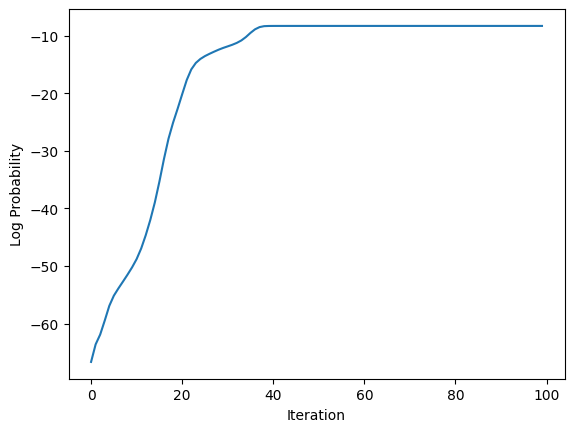

In [65]:
plot_prob(prob_arr, 100)

### View HMM

[0. 1.]


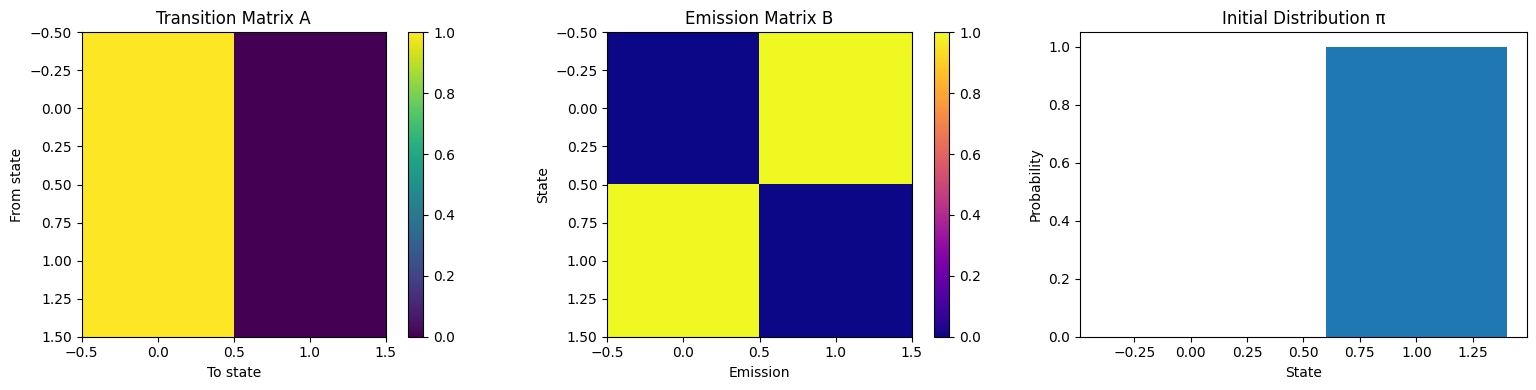

In [66]:
viewHMM(A, B, pi)
print(pi)

### View states:

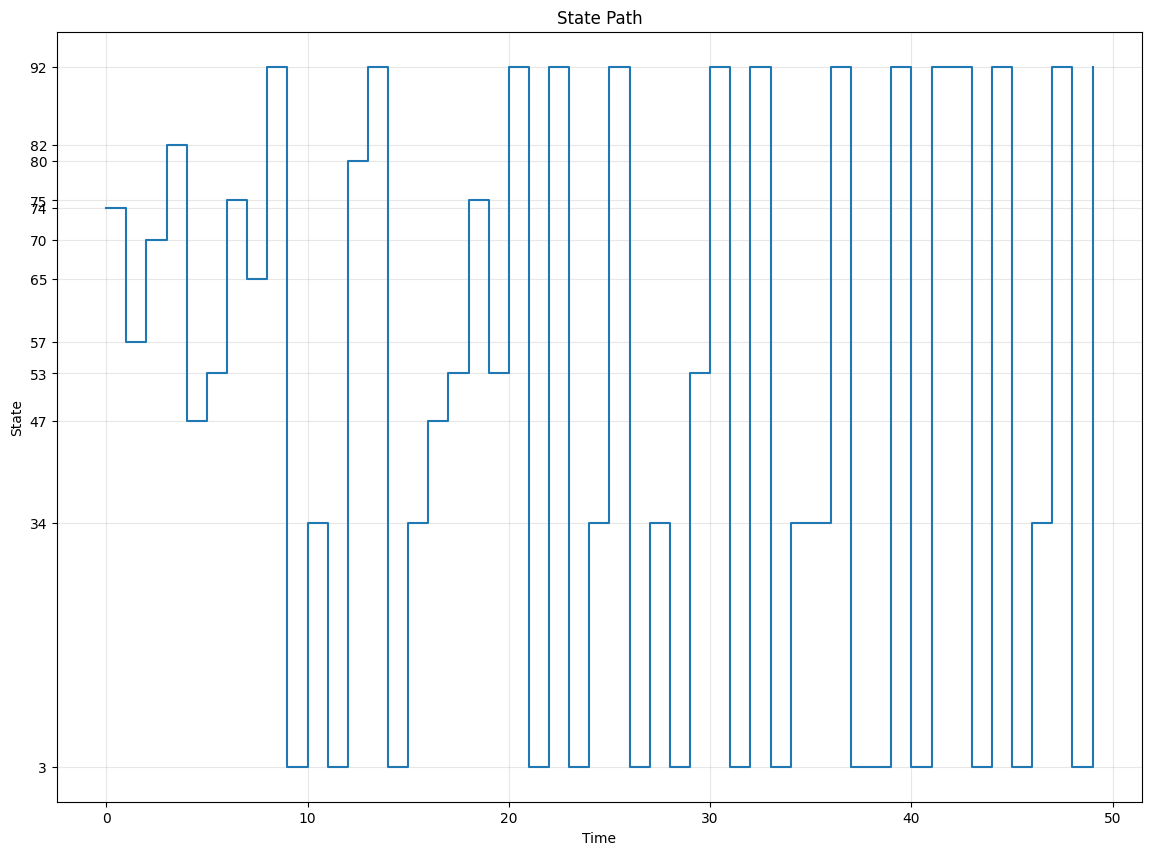

In [67]:
plot_state_path(states)


# Task : POS labeling

Khác với bài toán thời tiết (không giám sát, dùng Baum-Welch), ở đây chúng ta có dữ liệu huấn luyện *đã được gán nhãn* (biết cả từ và nhãn từ loại của nó).

Do đó, ta có thể ước lượng các tham số $\lambda = (A, B, \pi)$ bằng cách đếm trực tiếp tần suất của chúng từ tập `train_sents`:

1.  **Vector $\pi$ (Initial Probabilities):** Đếm tần suất một nhãn (ví dụ: 'NOUN') xuất hiện ở *đầu* câu.
    - $\pi_i = \frac{\text{Số câu bắt đầu bằng nhãn } i}{\text{Tổng số câu}}$

2.  **Ma trận A (Transition Probabilities):** Đếm tần suất một nhãn (ví dụ: 'VERB') xuất hiện *sau* một nhãn khác (ví dụ: 'NOUN').
    - $a_{ij} = P(q_{t+1} = \text{nhãn } j | q_t = \text{nhãn } i) = \frac{\text{Số lần (nhãn i, nhãn j) xuất hiện}}{\text{Số lần nhãn i xuất hiện}}$

3.  **Ma trận B (Emission Probabilities):** Đếm tần suất một từ (ví dụ: 'book') được sinh ra từ một nhãn (ví dụ: 'NOUN').
    - $b_j(k) = P(O_t = \text{từ } k | q_t = \text{nhãn } j) = \frac{\text{Số lần (từ k, nhãn j) xuất hiện}}{\text{Số lần nhãn j xuất hiện}}$

In [68]:
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import warnings


##  Tải và chuẩn bị dữ liệu

In [69]:
nltk.download('universal_tagset')
nltk.download('treebank')
tagged_sents = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

print(f"Total sents: {len(tagged_sents)}")
print("Example:", tagged_sents[0])
print("-" * 30)
train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)

print(f"Train: {len(train_sents)}")
print(f"Test: {len(test_sents)}")

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Total sents: 3914
Example: [('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
------------------------------
Train: 3131
Test: 783


## Xây dựng Vocabulary và Ánh xạ (Mappings)

In [70]:


vocab = set()
tags = set()
for sent in train_sents:
    for word, tag in sent:
        vocab.add(word)
        tags.add(tag)

vocab.add("<UNK>")
UNK_TOKEN = "<UNK>"


word_to_id = {word: i for i, word in enumerate(vocab)}
tag_to_id = {tag: i for i, tag in enumerate(tags)}

id_to_word = {i: word for word, i in word_to_id.items()}
id_to_tag = {i: tag for tag, i in tag_to_id.items()}

UNK_ID = word_to_id[UNK_TOKEN]

N = len(tags)
M = len(vocab)

print(f"Number of tags: {N}")
print(f"Number of observations: {M}")
print("Tags:", tags)


Number of tags: 12
Number of observations: 11050
Tags: {'ADP', 'ADJ', 'NUM', 'VERB', 'ADV', 'DET', 'PRT', 'CONJ', 'PRON', 'X', 'NOUN', '.'}


## Huấn luyện (Tính toán A, B, pi) - Supervised Training

In [71]:


pi = np.zeros(N) + 1
A = np.zeros((N, N)) + 1
B = np.zeros((N, M)) + 1
for sent in train_sents:
    if not sent:
        continue

    start_tag_id = tag_to_id[sent[0][1]]
    pi[start_tag_id] += 1

    for i in range(len(sent)):
        word, tag = sent[i]
        word_id = word_to_id.get(word, UNK_ID)
        tag_id = tag_to_id[tag]

        B[tag_id, word_id] += 1

        if i < len(sent) - 1:
            next_tag = sent[i+1][1]
            next_tag_id = tag_to_id[next_tag]
            A[tag_id, next_tag_id] += 1
pi = pi / np.sum(pi)
A = A / np.sum(A, axis=1, keepdims=True)
B = B / np.sum(B, axis=1, keepdims=True)





## Đánh giá mô hình (Evaluation)

Total words: 20549
Correct words: 18411
              precision    recall  f1-score   support

           .       0.96      1.00      0.98      2354
         ADJ       0.79      0.70      0.75      1316
         ADP       0.86      0.97      0.91      2028
         ADV       0.86      0.70      0.77       634
        CONJ       1.00      0.99      0.99       471
         DET       0.78      0.96      0.86      1795
        NOUN       0.93      0.89      0.91      5943
         NUM       0.95      0.76      0.84       727
        PRON       0.91      0.97      0.94       523
         PRT       0.90      0.94      0.92       658
        VERB       0.92      0.84      0.88      2740
           X       0.90      0.93      0.91      1360

    accuracy                           0.90     20549
   macro avg       0.90      0.89      0.89     20549
weighted avg       0.90      0.90      0.89     20549



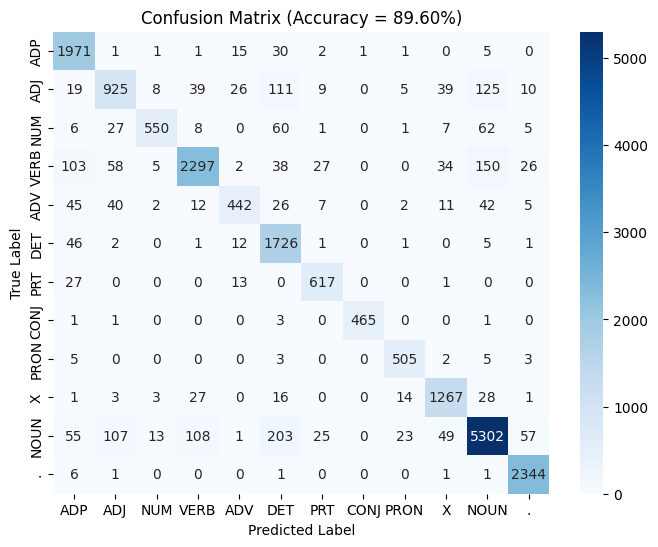

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

total_words = 0
correct_words = 0
all_true_tags = []
all_pred_tags = []

for sent in test_sents:
    if not sent:
        continue
    obs_sequence = []
    true_tags_ids = []

    for word, tag in sent:
        word_id = word_to_id.get(word, UNK_ID)
        obs_sequence.append(word_id)
        true_tags_ids.append(tag_to_id[tag])

    predicted_tags_ids, _, _ = viterbi(obs_sequence, A, B, pi)

    all_true_tags.extend(true_tags_ids)
    all_pred_tags.extend(predicted_tags_ids)

    for true_tag, pred_tag in zip(true_tags_ids, predicted_tags_ids):
        total_words += 1
        if true_tag == pred_tag:
            correct_words += 1

accuracy = (correct_words / total_words) * 100 if total_words else 0
print(f"Total words: {total_words}")
print(f"Correct words: {correct_words}")
true_labels = [id_to_tag[i] for i in all_true_tags]
pred_labels = [id_to_tag[i] for i in all_pred_tags]
tag_names = list(tag_to_id.keys())
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=tag_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f}%)")
plt.show()


In [73]:
def tag(s : str):
  obs_sequence = []
  word_sequence = []

  for word in s.split(" "):
      word_id = word_to_id.get(word, UNK_ID)
      word_sequence.append(word)
      obs_sequence.append(word_id)

  predicted_tags_ids, _, _ = viterbi(obs_sequence, A, B, pi)
  return [
      {"Word" : word_sequence[i], "Tag": id_to_tag[predicted_tags_ids[i]]} for i in range(len(predicted_tags_ids))
  ]

In [107]:
# POS tagging
print( "POS tagging", tag("I have a hot dog") )

print("")

# Weather prediction
print( "Weather prediction", weather_next(10, True)  )

# Weather prediction, custom observation
# 0 = clear / sunny
# 1 = clouddy
# 2 = rainny
print( "Weather, custom", weather_next(10, True, obs = [0, 2, 0, 1, 0, 0, 1]) )

POS tagging [{'Word': 'I', 'Tag': 'PRON'}, {'Word': 'have', 'Tag': 'VERB'}, {'Word': 'a', 'Tag': 'DET'}, {'Word': 'hot', 'Tag': 'ADJ'}, {'Word': 'dog', 'Tag': 'NOUN'}]

Weather prediction ['⛅', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅']
Weather, custom ['☀️', '☀️', '⛅', '☀️', '☀️', '⛅', '☀️', '☀️', '⛅', '☀️']
